# Trabajo 3: Redes Neuronales

### Integrantes:

- Jessica Bilbao Restrepo
- Santiago Gómez Montoya

# Problema: Clasificación de Imágenes de Aves de India

El data set utilizado contiene 15.000 imágenes de aves comunes de India, las cuales se dividen en 25 categorías distintas (600 imágenes cada categoría). Adicionalmente, cada categoría se ha dividido en 2 grupos donde 550 imágenes pertenecen a `/train` y 50 imágenes pertenencen a `/valid`. Es decir que de las 15.000 imágenes 13.750 son para entrenamiento y 1250 para validacion.

Se desea realizar una red neuronal que permita clasificar estas 25 especies de aves y para ello, se utiliza la técnica de Transferencia de Aprendizaje (Transfer Learning) para utilizar una red previamente entrenada y desarrollar un nuevo modelo.



___

## Modelo elegido: EfficientNetV2B0

Este modelo se eligió debido a que, según lo investigado, EfficientNet es un tipo de arquitetura que ayuda a maximizar el rendimiento y la eficiencia de los recursos usados para correr el modelo, mejorando además la precisión en la clasificación de imagenes, además que cuenta con una buena profundidad que puede ser buena para la cantidad de imagenes que estamos usando para el entrenamiento. Se usó EfficientNetV2 ya que es una versión mejorada de la arquitectura haciendo el modelo un poco más rápido.

In [1]:
from tensorflow import keras

base_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

In [2]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

## Congelamos el modelo y agregamos nuevas capas

Se tuvo en cuenta sobre todo el uso de capas como Dropout, BatchNormalization y Maxpooling para tratar de evitar el sobre-entrenamiento del modelo

In [3]:
base_model.trainable = False

In [6]:
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.MaxPooling2D((2, 2), strides=2, padding="same")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.MaxPooling2D((2, 2), strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(25, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 1280)       0         
 2D)                                                             
                                                                 
 dense_1 (Dense)             (None, 4, 4, 512)         655872    
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                             

## Compilamos el modelo

In [8]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## Se hace el proceso de data augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.5, 1.5],
) 

datagen_valid = ImageDataGenerator(samplewise_center=True)

In [10]:
batch_size = 128

train = datagen_train.flow_from_directory(
    "filtered_training_set/train/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
)


valid = datagen_valid.flow_from_directory(
    "filtered_training_set/valid/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
)

Found 13750 images belonging to 25 classes.
Found 1250 images belonging to 25 classes.


## Muestreo de imagenes generadas

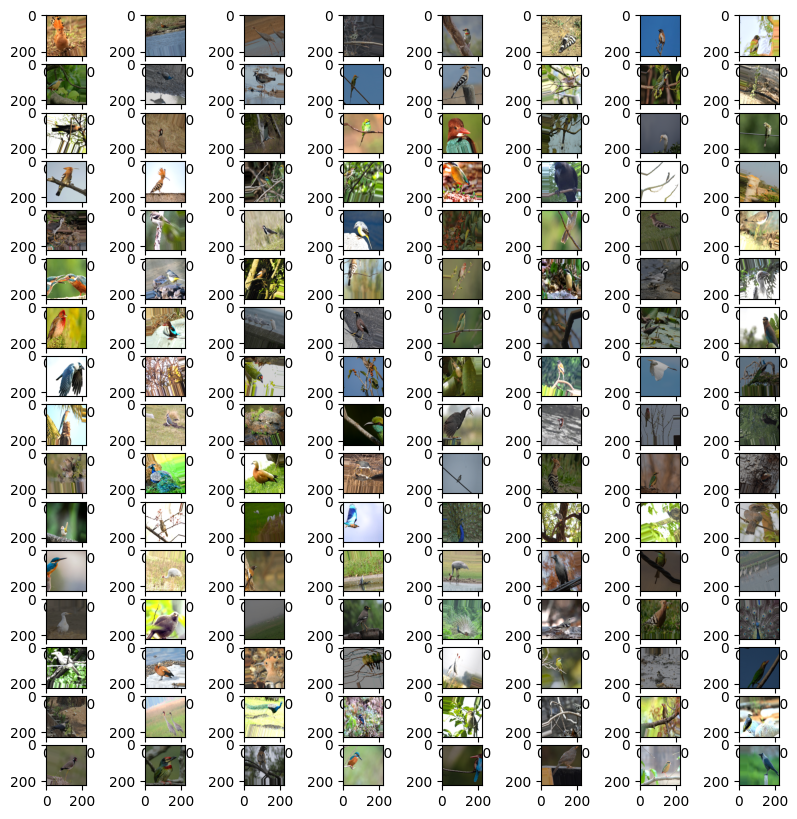

In [11]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 128
x, y = train.next()
fig, ax = plt.subplots(nrows=16, ncols=8, figsize = (10,10))
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(image/255)
plt.show()

## Se entrena el modelo

#### Se intenta cumplir con la fórmula `steps * batch_size = number_of_images_trained in an epoch` 
#### steps_per_epoch = 13750 / 128 = 107 (Se elige 100)
#### validation_steps = 1250 / 128 = 9,7 (Se elige 9)

In [12]:
model.fit(train, steps_per_epoch=100, validation_data=valid, validation_steps=9, epochs=10)

Epoch 1/10
100/100 [==============================] - 456s 4s/step - loss: 1.2247 - accuracy: 0.6753 - val_loss: 2.1690 - val_accuracy: 0.4080
Epoch 2/10
100/100 [==============================] - 443s 4s/step - loss: 0.5310 - accuracy: 0.8486 - val_loss: 2.1412 - val_accuracy: 0.4323
Epoch 3/10
100/100 [==============================] - 441s 4s/step - loss: 0.4069 - accuracy: 0.8800 - val_loss: 2.2651 - val_accuracy: 0.4323
Epoch 4/10
100/100 [==============================] - 443s 4s/step - loss: 0.3845 - accuracy: 0.8919 - val_loss: 2.2251 - val_accuracy: 0.4210
Epoch 5/10
100/100 [==============================] - 442s 4s/step - loss: 0.3455 - accuracy: 0.9048 - val_loss: 2.4369 - val_accuracy: 0.4314
Epoch 6/10
100/100 [==============================] - 438s 4s/step - loss: 0.3254 - accuracy: 0.9086 - val_loss: 2.5706 - val_accuracy: 0.4054
Epoch 7/10
100/100 [==============================] - 440s 4s/step - loss: 0.2884 - accuracy: 0.9186 - val_loss: 2.7447 - val_accuracy: 0.4184

## Se aplica Fine-tunning

In [13]:
base_model.trainable = True

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
model.fit(train, steps_per_epoch=100, validation_data=valid, validation_steps=9, epochs=10)

Epoch 1/10
100/100 [==============================] - 1127s 11s/step - loss: 0.1831 - categorical_accuracy: 0.9477 - val_loss: 2.5784 - val_categorical_accuracy: 0.4314
Epoch 2/10
100/100 [==============================] - 1117s 11s/step - loss: 0.1669 - categorical_accuracy: 0.9524 - val_loss: 2.4855 - val_categorical_accuracy: 0.4401
Epoch 3/10
100/100 [==============================] - 1053s 11s/step - loss: 0.1494 - categorical_accuracy: 0.9569 - val_loss: 2.4698 - val_categorical_accuracy: 0.4523
Epoch 4/10
100/100 [==============================] - 1051s 10s/step - loss: 0.1499 - categorical_accuracy: 0.9585 - val_loss: 2.4255 - val_categorical_accuracy: 0.4592
Epoch 5/10
100/100 [==============================] - 1074s 11s/step - loss: 0.1402 - categorical_accuracy: 0.9584 - val_loss: 2.4587 - val_categorical_accuracy: 0.4531
Epoch 6/10
100/100 [==============================] - 1047s 10s/step - loss: 0.1351 - categorical_accuracy: 0.9631 - val_loss: 2.4654 - val_categorical_acc

## Se evalua la precisión

In [15]:
test_loss, test_acc = model.evaluate(valid)

10/10 [==============================] - 28s 3s/step - loss: 2.5955 - categorical_accuracy: 0.4392


Nuestro modelo tuvo un comportamiento que indica que tuvo overfitting, solo pudo lograrse un 43% de precisión con los datos de validación. Se intentaron diferentes variaciones en cuanto a las capas que se añadieron pero no se logró aumentar este valor

In [16]:
model.save('BirdsM6.h5')